# Multi-modal Emotion Classification Model
This model takes a late fusion approach to classify the overall emotion. The model takes in probability distribbutions from each classifiers (tone, facial expression, semantics) and learns the patterns from them to predict the overall emotion.

### Install packages

In [ ]:
import sys
print(sys.executable)
# !{sys.executable} -m pip install -r requirements.txt

/Users/rkawagoe/Documents/SFU/Courses/CMPT419/Project/CMPT419_Project/venv/bin/python
  Using cached matplotlib-3.9.4-cp39-cp39-macosx_11_0_arm64.whl (7.8 MB)
  Using cached kiwisolver-1.4.7-cp39-cp39-macosx_11_0_arm64.whl (64 kB)
  Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
     |████████████████████████████████| 111 kB 3.3 MB/s eta 0:00:01
  Using cached importlib_resources-6.5.2-py3-none-any.whl (37 kB)
  Using cached pillow-11.1.0-cp39-cp39-macosx_11_0_arm64.whl (3.1 MB)
  Using cached contourpy-1.3.0-cp39-cp39-macosx_11_0_arm64.whl (249 kB)
  Using cached fonttools-4.56.0-cp39-cp39-macosx_10_9_universal2.whl (2.8 MB)
You should consider upgrading via the '/Users/rkawagoe/Documents/SFU/Courses/CMPT419/Project/CMPT419_Project/venv/bin/python -m pip install --upgrade pip' command.


### Import packages

In [34]:
import torch
import torch.nn as nn
import pandas as pd
from torch.utils.data import DataLoader, SubsetRandomSampler
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import ast
import matplotlib

### Data preparation

In [20]:
from data_loader import MultiModalEmotionDataset

# Load data from csv file
train_data_path = "data/fusion_training_data.csv"
val_data_path = "data/fusion_validation_data.csv"

train_data = pd.read_csv(train_data_path)
val_data = pd.read_csv(val_data_path)

modality_probs = ['tone_prediction', 'face_prediction', 'semantic_prediction']
for modality in modality_probs:
    train_data[modality] = train_data[modality].apply(ast.literal_eval)
    val_data[modality] = val_data[modality].apply(ast.literal_eval)

# Create data loaders
BATCH_SIZE = 64
train_dataset = MultiModalEmotionDataset(dataframe=train_data, prob_columns=modality_probs, label_column='emotion')
val_dataset = MultiModalEmotionDataset(dataframe=val_data, prob_columns=modality_probs, label_column='emotion')
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)


Total rows in dataset: 1000
Total rows in dataset: 200


### Model Architecture

In [21]:
class LateFusionEmotionClassifier(nn.Module):
    def __init__(self, input_dim=18, output_dim=6):
        super(LateFusionEmotionClassifier, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, output_dim)
        )
       
    def forward(self, x):
        return self.net(x)

### Training and validation process

In [28]:
def train(model, device, criterion, train_loader, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for i, (x_batch, y_batch, original_index) in enumerate(train_loader):

        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(x_batch)

        # Compute loss
        loss = criterion(outputs, y_batch)

        # Backward pass
        loss.backward()

        # Optimize the model
        optimizer.step()

        # Calculate accuracy
        predicted = torch.argmax(outputs, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

        running_loss += loss.item()

    # statistics for the epoch
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total
    return epoch_loss, epoch_accuracy

def validate(model, device, val_loader):
    model.eval()
    correct = 0
    total = 0
    labels = []
    predictions = []

    with torch.no_grad():
        for x_batch, y_batch, original_index in val_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model(x_batch)
            _, batch_preds = torch.max(outputs, 1)
            correct += (batch_preds == y_batch).sum().item()
            total += y_batch.size(0)
            labels.extend(y_batch.cpu().numpy())
            predictions.extend(batch_preds.cpu().numpy())

    return labels, predictions


### Cross-Validation

In [ ]:
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Cross-validation:")
for fold, (train_idx, val_idx) in enumerate(kf.split(train_dataset)):
    print(f">> Fold [{fold + 1}/{k}]")
    print("Training:")

    fold_train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=SubsetRandomSampler(train_idx))
    fold_val_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=SubsetRandomSampler(val_idx))

    # Training
    model = LateFusionEmotionClassifier(input_dim=18, output_dim=6).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    num_epochs = 100

    for epoch in range(num_epochs):
        epoch_loss, epoch_accuracy = train(model, device, criterion, fold_train_loader, optimizer)
        print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")

    # Validation
    print("Validation:")
    true_labels, pred_labels = validate(model, device, fold_val_loader)
    


print("Cross-validation completed.")

Cross-validation:
>> Fold [1/5]
Training:
Epoch [1/100] Loss: 1.7996, Accuracy: 16.5000
Epoch [2/100] Loss: 1.7961, Accuracy: 15.2500
Epoch [3/100] Loss: 1.7927, Accuracy: 16.1250
Epoch [4/100] Loss: 1.7908, Accuracy: 17.7500
Epoch [5/100] Loss: 1.7903, Accuracy: 17.7500
Epoch [6/100] Loss: 1.7891, Accuracy: 18.3750
Epoch [7/100] Loss: 1.7879, Accuracy: 18.6250
Epoch [8/100] Loss: 1.7865, Accuracy: 21.3750
Epoch [9/100] Loss: 1.7850, Accuracy: 23.5000
Epoch [10/100] Loss: 1.7854, Accuracy: 23.6250
Epoch [11/100] Loss: 1.7822, Accuracy: 22.3750
Epoch [12/100] Loss: 1.7800, Accuracy: 23.7500
Epoch [13/100] Loss: 1.7777, Accuracy: 23.2500
Epoch [14/100] Loss: 1.7757, Accuracy: 21.5000
Epoch [15/100] Loss: 1.7730, Accuracy: 23.5000
Epoch [16/100] Loss: 1.7720, Accuracy: 22.8750
Epoch [17/100] Loss: 1.7664, Accuracy: 24.5000
Epoch [18/100] Loss: 1.7648, Accuracy: 22.5000
Epoch [19/100] Loss: 1.7636, Accuracy: 22.5000
Epoch [20/100] Loss: 1.7603, Accuracy: 23.8750
Epoch [21/100] Loss: 1.7623

### Training

In [ ]:
model = LateFusionEmotionClassifier(input_dim=18, output_dim=6).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 200

print("Training:")
for epoch in range(num_epochs):
    epoch_loss, epoch_accuracy = train(model, device, criterion, train_loader, optimizer)
    print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")

    # Early termination
    if epoch_accuracy > 70:
        print("Early termination. Saving model.")
        model_path = f'./saved_models/multimodal_emotion_recognition_model_{epoch}_early.pth'
        torch.save(model.state_dict(), model_path)
        break

    # Final epoch
    if epoch == num_epochs - 1:
        print("Reached final epoch. Saving model.")
        model_path = f'./saved_models/multimodal_emotion_recognition_model_{epoch}_final.pth'
        torch.save(model.state_dict(), model_path)
        break

    # Save model periodically
    interval = 10
    if epoch % interval == 0:
        model_path = f'./saved_models/multimodal_emotion_recognition_model_{epoch}_intermediate.pth'
        torch.save(model.state_dict(), model_path)

print(f'Training completed. Final model path: {model_path}')


Training:
Epoch [1/200] Loss: 1.7951, Accuracy: 17.7000
Epoch [2/200] Loss: 1.7922, Accuracy: 17.7000
Epoch [3/200] Loss: 1.7914, Accuracy: 17.7000
Epoch [4/200] Loss: 1.7904, Accuracy: 17.7000
Epoch [5/200] Loss: 1.7898, Accuracy: 17.8000
Epoch [6/200] Loss: 1.7892, Accuracy: 18.3000
Epoch [7/200] Loss: 1.7883, Accuracy: 18.7000
Epoch [8/200] Loss: 1.7875, Accuracy: 21.0000
Epoch [9/200] Loss: 1.7857, Accuracy: 19.3000
Epoch [10/200] Loss: 1.7843, Accuracy: 21.3000
Epoch [11/200] Loss: 1.7838, Accuracy: 21.6000
Epoch [12/200] Loss: 1.7818, Accuracy: 20.1000
Epoch [13/200] Loss: 1.7801, Accuracy: 21.2000
Epoch [14/200] Loss: 1.7772, Accuracy: 21.2000
Epoch [15/200] Loss: 1.7761, Accuracy: 22.0000
Epoch [16/200] Loss: 1.7751, Accuracy: 20.9000
Epoch [17/200] Loss: 1.7726, Accuracy: 22.4000
Epoch [18/200] Loss: 1.7725, Accuracy: 22.2000
Epoch [19/200] Loss: 1.7686, Accuracy: 21.9000
Epoch [20/200] Loss: 1.7688, Accuracy: 23.6000
Epoch [21/200] Loss: 1.7663, Accuracy: 22.9000
Epoch [22/20

### Validation

Validation:
              precision    recall  f1-score   support

       angry       0.24      0.36      0.29        33
     disgust       0.26      0.26      0.26        34
     fearful       0.15      0.12      0.14        32
       happy       0.09      0.10      0.09        31
     neutral       0.27      0.19      0.22        32
         sad       0.13      0.11      0.12        38

    accuracy                           0.19       200
   macro avg       0.19      0.19      0.19       200
weighted avg       0.19      0.19      0.19       200



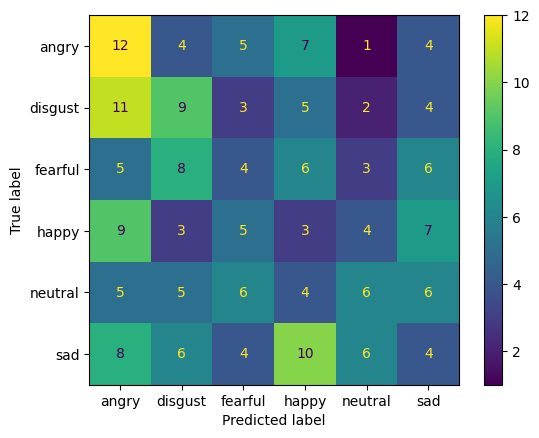

In [35]:
print("Validation:")
true_labels, pred_labels = validate(model, device, val_loader)

# Performance metrics report
label_mapping = { 0: 'angry', 1: 'disgust', 2: 'fearful', 3: 'happy', 4: 'neutral', 5: 'sad' }
print(classification_report(true_labels, pred_labels, labels=list(label_mapping.keys()), target_names=list(label_mapping.values())))

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, pred_labels, labels=list(label_mapping.keys()))
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1, keepdims=True)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=label_mapping.values())
disp.plot()

### Visualize output

In [36]:
print("\n--- Predictions vs True Labels ---")
label_map = {0: 'angry', 1: 'disgust', 2: 'fearful', 3: 'happy', 4: 'neutral', 5: 'sad'}

for i, (t, p) in enumerate(zip(true_labels, pred_labels)):
    print(f"Sample {i:03}: True = {label_map[t.item()]}, Pred = {label_map[p.item()]}")



--- Predictions vs True Labels ---
Sample 000: True = neutral, Pred = disgust
Sample 001: True = neutral, Pred = sad
Sample 002: True = sad, Pred = fearful
Sample 003: True = neutral, Pred = disgust
Sample 004: True = angry, Pred = happy
Sample 005: True = neutral, Pred = neutral
Sample 006: True = neutral, Pred = disgust
Sample 007: True = fearful, Pred = disgust
Sample 008: True = happy, Pred = sad
Sample 009: True = fearful, Pred = happy
Sample 010: True = angry, Pred = fearful
Sample 011: True = happy, Pred = neutral
Sample 012: True = fearful, Pred = sad
Sample 013: True = angry, Pred = happy
Sample 014: True = fearful, Pred = disgust
Sample 015: True = disgust, Pred = happy
Sample 016: True = disgust, Pred = disgust
Sample 017: True = angry, Pred = angry
Sample 018: True = fearful, Pred = sad
Sample 019: True = disgust, Pred = fearful
Sample 020: True = disgust, Pred = disgust
Sample 021: True = sad, Pred = fearful
Sample 022: True = fearful, Pred = happy
Sample 023: True = angr